In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from IPython import display

In [2]:
env = gym.make("Taxi-v3")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
s = env.reset()
print(f"Initial state: {s}")
env.render()

Action space: Discrete(6)
Observation space: Discrete(500)
Initial state: 309
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [4]:
policy = np.ones((n_states, n_actions), dtype="float") / n_actions
policy

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

In [5]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

In [6]:
def generate_session(policy, t_max=int(10**4)):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        a = np.random.choice(n_actions, p=policy[s])
        new_s, r, done, info = env.step(a)

        # Record state, action and add up reward to states,actions and total_reward accordingly.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
            
    return states, actions, total_reward

In [7]:
s, a, r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

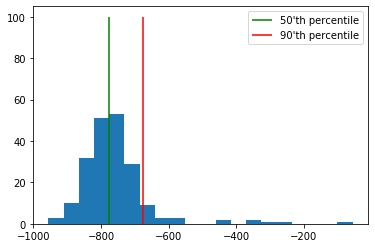

In [8]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [9]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    
#     elite_states = [s for idx, s in enumerate(states_batch) if rewards_batch[idx] >= reward_threshold]
#     elite_actions = [a for idx, a in enumerate(actions_batch) if rewards_batch[idx] >= reward_threshold]

    elite_mask = np.asarray(rewards_batch) >= reward_threshold
    elite_states = np.asarray(states_batch)[elite_mask]
    elite_actions = np.asarray(actions_batch)[elite_mask]

    return np.concatenate(elite_states), np.concatenate(elite_actions)

In [10]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]

rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)

test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)

test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)

test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [11]:
def update_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])
    
    for idx, s in enumerate(elite_states):
        new_policy[s, elite_actions[idx]] += 1.
        
    never_visited_mask = new_policy.sum(axis=1) == 0.
    new_policy[never_visited_mask] = 1.

    new_policy /= new_policy.sum(axis=1)[:, None]
    
    return new_policy

In [12]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."

assert np.all(
    new_policy >= 0
), "Your new policy can't have negative action probabilities"

assert np.allclose(
    new_policy.sum(
    axis=-1), 1
), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])

assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")

Ok!


In [13]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    display.clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [14]:
policy = np.ones([n_states, n_actions]) / n_actions

In [ ]:
n_sessions = 250  # sample this many sessions
percentile = 30  # take this percent of session with highest rewards
learning_rate = 0.5  # add this thing to all counts for stability

log = []

for i in range(100):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    #  [ < generate a list of n_sessions new sessions > ]

    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
#     mean_reward = np.mean(rewards_batch)
#     log.append(mean_reward)
    
    if i+1 % 5:
        learning_rate *= 0.99
    
    elite_states, elite_actions = select_elites(
        states_batch, 
        actions_batch, 
        rewards_batch, 
        percentile=percentile
    )

    new_policy = update_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1-learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

In [ ]:
import time

s = env.reset()

while True:
    a = np.random.choice(n_actions, p=policy[s])
    s, r, done, info = env.step(a)
    
    display.clear_output()
    env.render()
    time.sleep(1)
    
    if done:
        break

In [ ]:
env.close()